This notebook would study the possibilty of preempting customer churn so as to allow for the opportunity to intervene. As an analyst you have to understand who is leaving and why. Customers who have left in the last month are known as customers that have churned. This is thus the target you want to investigate, and you want to understand the characteristics associated with this target. All you do is a simple prediction excercise with a tree, understandable variables and feature importance measures for single and interaction variables. Another interesting feature is a wordcloud of important predictors. Here is an example of some wordclouds, https://nicholastsmith.wordpress.com/2017/08/16/using-random-forests-and-wordclouds-to-visualize-feature-importance-in-document-classification//

An important part now is the actuate on the knowledge that we have gathered. This is easy and can be done by formulating simple decision rules to identify the customers most at risk. This is done by identifying the important predictors and isolating those for which a large group of predictors point in a similat direction. I would recommend isolating no more than five variables and playing around with them as inputs to the model keeping all other variables stable at median or mean - good question as to which would be the most stable and then identify the liklihood to churn. What you can do is split the features by median in five pieces and then slowsly list the top ten most likley groups to fail. That is all you really need, I think it is a roundabout way of understand, but a useful method none the less.

In [1]:
import pandas as  pd

df = pd.read_csv("data/telco_churn.csv")

df.shape

(7043, 21)

tenure, MonthlyCharges and TotalCharges are not cateogical variables, hence they show large cardinality. The rest of the variables are indeed categorical, in this problem set, one hot encoding would work fine because of the low cardinality present. In applied machine learning you do not want to exploit leakages, you want to fix them.

In [2]:
df["SeniorCitizen"] = df["SeniorCitizen"].astype("object")

pd.options.display.max_rows = None

df["TotalChargesConv"] = pd.to_numeric(df["TotalCharges"], errors='coerce')

df["TotalChargesConv"].isnull().sum()

11

TotalCharges is completely missing. From further analysis, I am convinced that they are missed at random and that the fact that they are missing does not contain any value. So I would go ahead and just fill the values with the mean

In [3]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,TotalChargesConv
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,29.85
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,No,No,No,One year,No,Mailed check,56.95,1889.5,No,1889.50
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,108.15
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,1840.75
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,151.65


Here I would now also seek to see if there are more missing feature present.

In [3]:

def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

missing_data(df)

,Total,Percent
TotalChargesConv,11,0.156183
Churn,0,0.000000
gender,0,0.000000
SeniorCitizen,0,0.000000
Partner,0,0.000000
Dependents,0,0.000000
tenure,0,0.000000
PhoneService,0,0.000000
MultipleLines,0,0.000000
InternetService,0,0.000000


In [4]:
df["TotalChargesConv"] = df["TotalChargesConv"].fillna(df["TotalChargesConv"].mean())

del df["TotalCharges"]

import numpy as np
# Keeping 15% for the validation set, thats about 1000 instances to test on 
msk = np.random.rand(len(df)) < 0.15
df["is_test"] = msk

cols_drop = ["customerID","Churn", "is_test"]
id_target = df[cols_drop]

df = pd.get_dummies(df.drop(cols_drop, axis=1))
df = pd.concat((id_target, df),axis=1)

df["Churn"] = df["Churn"].apply(lambda x: 0 if x=="No" else 1)

## Immediately Remove High Correlates
corr_matrix = df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.90
to_drop = [column for column in upper.columns if any(upper[column] > 0.999999)]

In [7]:
to_drop

['gender_Male',
 'SeniorCitizen_1',
 'Partner_Yes',
 'Dependents_Yes',
 'PhoneService_Yes',
 'MultipleLines_No phone service',
 'OnlineSecurity_No internet service',
 'OnlineBackup_No internet service',
 'DeviceProtection_No internet service',
 'TechSupport_No internet service',
 'StreamingTV_No internet service',
 'StreamingMovies_No internet service',
 'PaperlessBilling_Yes']

In [8]:
df = df.drop(to_drop, axis=1)

In [9]:
train = df[df["is_test"]==False]

In [10]:
X_train = df[df["is_test"]==False].drop(cols_drop,axis=1)
y_train = df[df["is_test"]==False]["Churn"]




In [11]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier
import gc
import random

In [21]:
params = {
         'boosting_type': 'gbdt',
          'max_depth': 6,
          'objective': 'binary',
          'n_estimators': 5000, 
          'nthread': 12,
          'num_leaves': 32,
          'learning_rate': 0.02,
          'subsample': 0.85,
          'colsample_bytree': 0.95,
          'reg_alpha': 0.5,
          'reg_lambda': 0.8,
          'min_split_gain': 0.05,
          'min_child_weight': 40,
          'min_child_samples': 5,
          'metric': 'auc'}



def pars(n_estimator_bottom, n_estimator_top):
    return random.sample(range(n_estimator_bottom, n_estimator_bottom+ n_estimator_top), 8) + random.sample(range(n_estimator_bottom, int(n_estimator_bottom + n_estimator_top/np.log(n_estimator_top))), 6) + random.sample(range(n_estimator_bottom, int(n_estimator_bottom+(n_estimator_top/np.log(n_estimator_top))/np.log(n_estimator_top))), 4)

    #return random.sample(range(n_estimator_bottom, n_estimator_bottom+ n_estimator_top), 4) + random.sample(range(n_estimator_bottom, int(n_estimator_bottom + n_estimator_top/np.log(n_estimator_top))), 3) + random.sample(range(n_estimator_bottom, int(n_estimator_bottom+(n_estimator_top/np.log(n_estimator_top))/np.log(n_estimator_top))), 2)



mdl = LGBMClassifier(
    **params
)

gridParams = {
    'learning_rate': [0.02, 0.05],
    'n_estimators': pars(10,15000),
    'num_leaves': pars(20,100),
    'boosting_type' : ['gbdt'],
    'random_state' : [405], # Updated from 'seed'
    'colsample_bytree' : [round(random.uniform(0.7,1),2) for _ in range(18)] ,
    'subsample' : [round(random.uniform(.2,.95),2) for _ in range(18)] ,
    'reg_alpha' : [round(random.uniform(0.1,4),2) for _ in range(18)],
    'reg_lambda' : [round(random.uniform(0.1,4),2) for _ in range(18)],
    }

In [22]:
X_test = df.loc[df.is_test, :].drop(cols_drop, axis=1)
y_test = df.loc[df.is_test, :]["Churn"]

In [23]:
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score

n_splits = 5
cvv = StratifiedKFold(n_splits=n_splits, random_state=42)

oof_preds = np.zeros(X_train.shape[0])

sub = df.loc[df.is_test, :][cols_drop]
sub["Churn_Predict"] = 0
feature_importances = pd.DataFrame()
avg_iter = 0
for i, (fit_idx, val_idx) in enumerate(cvv.split(X_train, y_train)):
    
    X_fit = X_train.iloc[fit_idx]
    y_fit = y_train.iloc[fit_idx]
    X_val = X_train.iloc[val_idx]
    y_val = y_train.iloc[val_idx]
    
    model = LGBMClassifier(
**params
    )

    model.fit(
        X_fit,
        y_fit,
        eval_set=[(X_fit, y_fit), (X_val, y_val)],
        eval_names=('fit', 'val'),
        eval_metric='auc',
        early_stopping_rounds=150,
        verbose=False
    )
    
    print("itteration: ", model.best_iteration_)
    avg_iter += model.best_iteration_
    oof_preds[val_idx] = model.predict_proba(X_val, num_iteration=model.best_iteration_)[:, 1]
    sub['Churn_Predict'] += model.predict_proba(X_test, num_iteration=model.best_iteration_)[:,1]
    
    fi = pd.DataFrame()
    fi["feature"] = X_train.columns
    fi["importance"] = model.feature_importances_
    fi["fold"] = (i+1)
    
    feature_importances = pd.concat([feature_importances, fi], axis=0)
    
    print("Fold {} AUC: {:.8f}".format(i+1, roc_auc_score(y_val, oof_preds[val_idx])))
    
print('Full AUC score %.8f' % roc_auc_score(y_train, oof_preds)) 
print('Out of sample AUC: ', roc_auc_score(y_test, sub['Churn_Predict']/n_splits))
print("avg iteration: ",(avg_iter/n_splits))

itteration:  177
Fold 1 AUC: 0.86939524
itteration:  314
Fold 2 AUC: 0.85728010
itteration:  230
Fold 3 AUC: 0.84829261
itteration:  495
Fold 4 AUC: 0.84521372
itteration:  377
Fold 5 AUC: 0.85197786
Full AUC score 0.85256117
Out of sample AUC:  0.8286286199168862
avg iteration:  318.6


In [ ]:
## The splits seems to work well.
## You can take the average iteration above or use the process below.
## You can retrain below on an ensemble of different seeds to produce the final model

In [75]:
## This will work if ou change parameters to get the new iteration score. 

from lightgbm import cv
from lightgbm import Dataset


def get_score(X, y, usecols, params,seeder,depther):  
     dtrain = Dataset(X[usecols], y)
     params["max_depth"] = depther
     ## These are forced for variable importance
     params["feature_fraction"] = 0.9
     params["bagging_fraction"] = 0.9

     eval =  cv(params,
             dtrain,
             nfold=5,
             stratified=True,
             num_boost_round=20000,
             early_stopping_rounds=160, ## After it stopped how long should go on. 
             verbose_eval=20,
             #verbose_eval=-1,
             seed = seeder,
             show_stdv=True)
     return max(eval['auc-mean']), eval["auc-mean"].index(max(eval["auc-mean"]))
  
seed_dict = {}
for seeder, depther in zip([5, 1, 9 ,12, 20], [6,6,6,6,6]):  ## Here is where you add parameter adaptions
    score, seed_best = get_score(X_train,y_train ,list(X_train.columns), params, seeder,depther)
    seed_dict[seeder] = seed_best

## Lets see if a full dataset prediction validation outperforms.

[20]	cv_agg's auc: 0.843784 + 0.00821279
[40]	cv_agg's auc: 0.846575 + 0.00947819
[60]	cv_agg's auc: 0.848162 + 0.00912504
[80]	cv_agg's auc: 0.849335 + 0.00902077
[100]	cv_agg's auc: 0.850259 + 0.00888681
[120]	cv_agg's auc: 0.851368 + 0.008769
[140]	cv_agg's auc: 0.852178 + 0.00865427
[160]	cv_agg's auc: 0.852431 + 0.00848813
[180]	cv_agg's auc: 0.852657 + 0.00825845
[200]	cv_agg's auc: 0.852751 + 0.00810582
[220]	cv_agg's auc: 0.853085 + 0.00787604
[240]	cv_agg's auc: 0.853163 + 0.00771073
[260]	cv_agg's auc: 0.853307 + 0.00762619
[280]	cv_agg's auc: 0.853409 + 0.00761826
[300]	cv_agg's auc: 0.853207 + 0.00768979
[320]	cv_agg's auc: 0.853189 + 0.00778502
[340]	cv_agg's auc: 0.853249 + 0.00784857
[360]	cv_agg's auc: 0.853228 + 0.00789094
[380]	cv_agg's auc: 0.853026 + 0.00807676
[400]	cv_agg's auc: 0.852888 + 0.00812161
[420]	cv_agg's auc: 0.852822 + 0.0081956
[20]	cv_agg's auc: 0.844505 + 0.0153633
[40]	cv_agg's auc: 0.846352 + 0.0156829
[60]	cv_agg's auc: 0.847766 + 0.0153002
[80]	

In [163]:
## This process gives you 15% extra data, but you have no validation set. 
# This can of course be improved by saving the best iterations, which is what I would do
dip  = {}
dip[1] = [6, 5]
dip[2] = [6, 1]
dip[3] = [6, 9]
dip[4] = [6, 12]

dip[5] = [6, 20]

n_splits = 5
cvv = StratifiedKFold(n_splits=n_splits, random_state=42)

sub = df.loc[df.is_test, :][cols_drop]
sub["Churn_Predict"] = 0

feature_importances = pd.DataFrame()

ba= 0 
for i, r in enumerate(range(n_splits)):
    ba = ba + 1
    
    params["num_boost_round"] = seed_dict[dip[ba][1]]  
    params["seed"] = dip[ba][1]
    params["max_depth"] = dip[ba][0] # if you want to customise uncomment
    
    model = LGBMClassifier(
**params
    )

    model.fit(
        X_train,
        y_train,
        eval_metric='auc',
        verbose=False
    )
    
    preds = model.predict_proba(X_test, num_iteration=seed_dict[dip[ba][1]] )[:,1]
    sub['Churn_Predict'] += preds
    
    fi = pd.DataFrame()
    fi["feature"] = X_train.columns
    fi["importance"] = model.feature_importances_
    fi["fold"] = (i+1)
    
    feature_importances = pd.concat([feature_importances, fi], axis=0)
    print("Fold {} AUC: {:.8f}".format(i+1, roc_auc_score(y_test, preds)))
  

/Users/dereksnow/anaconda/envs/py36/lib/python3.6/site-packages/lightgbm/engine.py:99: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Fold 1 AUC: 0.82761689


/Users/dereksnow/anaconda/envs/py36/lib/python3.6/site-packages/lightgbm/engine.py:99: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Fold 2 AUC: 0.82700115


/Users/dereksnow/anaconda/envs/py36/lib/python3.6/site-packages/lightgbm/engine.py:99: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Fold 3 AUC: 0.82692065


/Users/dereksnow/anaconda/envs/py36/lib/python3.6/site-packages/lightgbm/engine.py:99: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Fold 4 AUC: 0.82756032


/Users/dereksnow/anaconda/envs/py36/lib/python3.6/site-packages/lightgbm/engine.py:99: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Fold 5 AUC: 0.82757338


In [26]:
print('Out of sample AUC: ', roc_auc_score(y_test, sub['Churn_Predict']/n_splits))

Out of sample AUC:  0.8246883227083832


In [77]:
feat_imp = feature_importances.groupby("feature").mean().sort_values("importance", ascending=False)

feat_imp.head(10)

# if is_test shows significance it would point to leakage issue 

,importance,fold
feature,,
MonthlyCharges,694.6,3.0
TotalChargesConv,593.6,3.0
tenure,571.4,3.0
MultipleLines_No,130.0,3.0
PaymentMethod_Electronic check,123.6,3.0
OnlineSecurity_No,118.4,3.0
PaperlessBilling_No,113.6,3.0
Contract_Month-to-month,112.6,3.0
Contract_One year,108.0,3.0


In [28]:
## Often Times the cross-validation splits can just be completely ignored.

In [29]:
#180

In [79]:
import numpy as np
l = [x for x in seed_dict.values()]
best_iterations = np.mean(l)

best_iterations

252.8

In [ ]:
### best_iterations  394.6 for inst
### 252 -  litle subsample

In [80]:
import lightgbm as lgb
d_train = lgb.Dataset(X_train, label=y_train)
d_test = lgb.Dataset(X_test, label=y_test)
# 1.1 for no leaks, 0.7 used because best model feature importance 
# this slightly outperforms enemble but it leaks
params["num_boost_round"] = int(best_iterations*1.1) 
params["num_boost_round"] = int(best_iterations*1.1)


## Here you have to force feature fractions for predictor analysis


In [ ]:
import lightgbm as lgb

X_train = df[df["is_test"]==False].drop(cols_drop,axis=1)
y_train = df[df["is_test"]==False]["Churn"]

X_test = df.loc[df.is_test, :].drop(cols_drop, axis=1)
y_test = df.loc[df.is_test, :]["Churn"]

d_train = lgb.Dataset(X_train, label=y_train)
d_test = lgb.Dataset(X_test, label=y_test)

model = lgb.train(params, d_train, verbose_eval=1000)

In [176]:
best_iterations

252.8

In [181]:
import shap

params["num_boost_round"] = 10000
splits = 1
f = -1
for seeds in [15]:
    f = f +1
    print(seeds)
    params["feature_fraction_seed"] = seeds
    
    params["random_seed"] = seeds + 1
    
    params["feature_fraction"] = 0.2
    params["bagging_fraction"] = 0.2
    
    model = lgb.train(params, d_train, verbose_eval=1000)

    shap_values = shap.TreeExplainer(model).shap_values(df.drop(cols_drop, axis=1))

    shap_fram = pd.DataFrame(shap_values[:,:-1], columns=list(X_train.columns))

    shap_new = shap_fram.sum().sort_values().to_frame()

    shap_new.columns = ["SHAP"]

    shap_new["SHAP_abs"] = shap_new["SHAP"].abs()

    direction = df.corr()["Churn"].to_frame()
    direction.columns = ["corr"]
    shap_new = pd.merge(shap_new, direction, left_index=True, right_index=True, how="left")

    shap_new["abs_corr"] = shap_new["corr"].abs()
    
    if f==0:
        shap_fin = shap_new
    else:
        shap_fin = shap_fin + shap_new

shap_fin.loc[:,["SHAP","SHAP_abs","corr","abs_corr"]] = shap_fin.loc[:,["SHAP","SHAP_abs","corr","abs_corr"]]/splits

15


/Users/dereksnow/anaconda/envs/py36/lib/python3.6/site-packages/lightgbm/engine.py:99: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


In [174]:
cors_all  = df.corr()[df.corr().index.isin(list(shap_fin.index))].abs()
for b in cors_all.iloc[:,2:].columns:   # iloc to remove feature id columns
    cora = df.corr()[df.corr().index.isin(list(shap_fin.index))][b].abs()
    for c, v in zip(cora.index, cora.values):
        shap_fin["SHAP_corr_corrrected"].loc[c] = shap_fin["SHAP_corr_corrrected"].loc[c] + (shap_fin["SHAP_abs"].loc[b]/shap_fin["SHAP_abs"].max())*v

15


/Users/dereksnow/anaconda/envs/py36/lib/python3.6/site-packages/lightgbm/engine.py:99: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


1
6
7
2


In [ ]:
Effectively: Adjust for the fact that variables with low abs(SHAP) might be correlated with variables with high values.
Result: Smaller descrepencies between features, more stable with different feature selections and randomness (i.e. changes of bagging and feature fractions as well as seeds), won't mistakenly get rid of a feature that might have causal, albeit substitutable, importance   

To test it:
1. Tried mutiple fraction alternatives.
2. Averaged over multiple retakes for different seeds
3. Take the product of the relative (to max) portion of subject variable's SHAP_abs values and the associated correlation
      a)  shap_fin["SHAP_Corr_Corrrected"].loc[c] = shap_fin["SHAP_Corr_Corrrected"].loc[c] + (shap_fin["SHAP_abs"].loc[b]/shap_fin["SHAP_abs"].max())*v
    



In [ ]:
The SHAP_corr_corrected value is the

In [88]:
shap_fin["SHAP_corr"] = shap_fin["SHAP_Corr_Corrrected"].copy()

shap_fin["SHAP_corr"] = shap_fin["SHAP_corr"]/(shap_fin["SHAP_corr"].max()/shap_fin["SHAP_abs"].max())

shap_fin["SHAP_Corr_Corrrected"] = shap_fin["SHAP_Corr_Corrrected"]/(shap_fin["SHAP_Corr_Corrrected"].max()/shap_fin["SHAP_abs"].max())

shap_fin["SHAP_Corr_Corrrected"] = shap_fin["SHAP_Corr_Corrrected"] + shap_fin["SHAP_abs"]

shap_fin["SHAP_Corr_Corrrected"] = shap_fin["SHAP_Corr_Corrrected"]/(shap_fin["SHAP_Corr_Corrrected"].max()/shap_fin["SHAP_abs"].max())

In [90]:
shap_fin.sort_values('SHAP_corr', ascending=False).head(10)

,SHAP,Largest_Effect,SHAP_abs,corr,direction,abs_corr,SHAP_corr_corrrected,SHAP_corr
Contract_Month-to-month,906.785271,+++++,906.785271,0.405103,+++++,0.405103,906.785271,906.785271
tenure,-308.250063,-----,308.250063,-0.352229,-----,0.352229,516.718340,725.186618
Contract_Two year,110.094202,+++++,110.094202,-0.302253,-----,0.302253,386.615172,663.136143
TotalChargesConv,-58.927057,-----,58.927057,-0.199428,-----,0.199428,311.159987,563.392916
TechSupport_No,-170.060887,-----,170.060887,0.337281,+++++,0.337281,349.015912,527.970937
Contract_One year,-130.124222,-----,130.124222,-0.177820,-----,0.177820,316.545191,502.966159
OnlineSecurity_No,-68.364262,-----,68.364262,0.342637,+++++,0.342637,270.712949,473.061636
DeviceProtection_No,-0.006343,--+++,0.732087,0.252481,+++++,0.252481,215.028381,429.324675
PaymentMethod_Electronic check,-88.616541,-----,88.616541,0.301919,+++++,0.301919,244.125871,399.635200
OnlineBackup_No,-14.979056,-----,14.979056,0.268005,+++++,0.268005,204.751625,394.524194


In [92]:
dans = pd.read_csv("amalgamated.csv")

In [93]:
dans.sort_values('SHAP_corr', ascending=False).head(10)

,Unnamed: 0,SHAP,Largest_Effect,SHAP_abs,corr,direction,abs_corr,SHAP_corr_corrrected,SHAP_corr
0,Contract_Month-to-month,89.722288,+++++,89.722288,0.405103,+++++,0.405103,89.722288,89.722288
1,tenure,-32.415159,-----,32.415159,-0.352229,-----,0.352229,55.615119,78.815078
2,Contract_Two year,56.824406,+++++,56.824406,-0.302253,-----,0.302253,67.805145,78.785884
3,TotalChargesConv,-2.957160,-+--+,11.577356,-0.199428,-----,0.199428,41.444353,71.311350
4,TechSupport_No,-3.145848,-+++-,10.992171,0.337281,+++++,0.337281,35.971348,60.950524
5,OnlineSecurity_No,6.738696,++++-,12.082303,0.342637,+++++,0.342637,35.709987,59.337670
6,InternetService_No,4.387260,++-+-,8.929218,-0.227890,-----,0.227890,32.621494,56.313771
7,InternetService_Fiber optic,8.872516,++-+-,13.110938,0.308020,+++++,0.308020,32.963081,52.815223
8,DeviceProtection_No,-3.105107,-+---,4.129762,0.252481,+++++,0.252481,27.780575,51.431389
9,OnlineBackup_No,-14.044804,----+,15.399742,0.268005,+++++,0.268005,33.136412,50.873081


In [74]:
### There is a way to prove that it works - using all. 
#shap_fin.sort_values('SHAP_corr', ascending=False).to_csv("amalgamated.csv")

In [ ]:
"SHAP values are sensitive to high correlations among different features. When features are correlated, their impact on the model score can be split among them in an infinite number of ways. This means that the SHAP values will be lower than if all but one of the correlated feature(s) had been removed from the model. "

My recommendation based on the SHAP_corr (adjusted shapely correlation values)
1. Only target customers who don't have internet or are less likley to get internet
2. Those who have paid more in the past are locked in by sunk cost and stay on for longer
3. Potentially lower the amount to get more clients
4. The longer a client has stayed on, the longer they are expected to stay on, the lindy effect, therefore get clients to stay on for longer, even if you trade at a loss at first.
5. Sign customers on for yearly and not month to month agreements
6. If you do target internet enabled customers, focus on those who do not have fiber.
7. Online Security and Tech support are markers for ineptness and clients who require this would less likley churn.
8. If they stream movies and tv they are more likley to churn, so these are two important questions to ask, I believe these proxy for competence and age i.e. liklihood to churn.


Here we try out the global feature importance calcuations that come with XGBoost. Note that they all contradict each other, which motivates the use of SHAP values since they come with consistency gaurentees (meaning they will order the features correctly).

In [39]:
shap_fin.sort_values("SHAP_corr_corrrected",ascending=False).head(20)

,SHAP,Largest_Effect,SHAP_abs,corr,direction,abs_corr,SHAP_corr_corrrected,SHAP_corr
Contract_Month-to-month,89.722288,+++++,89.722288,0.405103,+++++,0.405103,89.722288,77.623205
Contract_Two year,56.824406,+++++,56.824406,-0.302253,-----,0.302253,66.017732,66.308543
tenure,-32.415159,-----,32.415159,-0.352229,-----,0.352229,60.448009,80.329423
MonthlyCharges,-23.233877,---+-,23.831915,0.193356,+++++,0.193356,59.466914,87.082779
TotalChargesConv,-2.957160,-+--+,11.577356,-0.199428,-----,0.199428,53.569346,88.337491
InternetService_No,4.387260,++-+-,8.929218,-0.227890,-----,0.227890,52.892006,89.722288
InternetService_Fiber optic,8.872516,++-+-,13.110938,0.308020,+++++,0.308020,46.719933,74.028728
OnlineSecurity_No,6.738696,++++-,12.082303,0.342637,+++++,0.342637,44.640472,71.178857
TechSupport_No,-3.145848,-+++-,10.992171,0.337281,+++++,0.337281,43.851507,70.797451
OnlineBackup_No,-14.044804,----+,15.399742,0.268005,+++++,0.268005,40.939261,60.958105


In [ ]:
## I would argue that SHAP_corr are more causal in manner.
## Other shit is correlated with SHAP_corr, so if it falls away not too much issues.
shap_fin.sort_values("SHAP_corr",ascending=False).head(20)

In [ ]:
## New Number I want to TRY
shap_fin = shap_fin.sort_values("SHAP_abs",ascending=False)

In [ ]:
shap_new.to_csv("imp1.csv")

In [ ]:
preds = model.predict(X_test, num_iteration=model.best_iteration)

print('Out of sample AUC: ', roc_auc_score(y_test, preds))

In [ ]:
# To be truthfull the prediction excerse is not that interesting, what is more interesting
# fitting the data to the response, i.e. training the model and looking at the feature
# interactions it proposes. Feature importance is only interesting to the extent it is
# different to correlation plot, in that regard, higher dimensional interactions become
# important

In [ ]:
## To get direction use general df
## df.corr()["Churn"]
shap.summary_plot(shap_values, df.drop(cols_drop, axis=1))

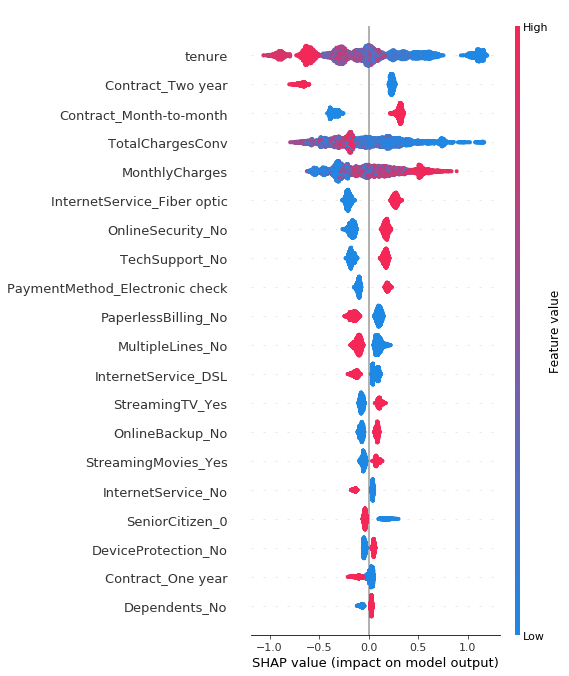

In [182]:
## To get direction use general df
## df.corr()["Churn"]
shap.summary_plot(shap_values, df.drop(cols_drop, axis=1))

## To get direction use general df
## df.corr()["Churn"]
shap.summary_plot(shap_values, df.drop(cols_drop, axis=1))

In [147]:



shap.TreeExplainer(xgb).shap_interaction_values(df.drop(cols_drop, axis=1))


NameError: name 'xgb' is not defined

In [148]:
shap_fram = pd.DataFrame(shap_values[:,:-1], columns=list(X_train.columns))

shap_new = shap_fram.sum().sort_values().to_frame()

shap_new.columns = ["SHAP"]

shap_new["Largest_Effect"] = shap_new["SHAP"].apply(lambda x: "-" if x<0else "+")

shap_new["SHAP_abs"] = shap_new["SHAP"].abs()

In [149]:
df.drop(cols_drop, axis=1).shape

(7043, 33)

In [150]:
print('Out of sample AUC: ', roc_auc_score(y_test, preds))

Out of sample AUC:  0.8275733774286896


In [151]:
## Here at this point, you migth want to investigate individual mistakes from the validation
## set
## You can simply focus on train on validation instead of train on test.
## However I doubt any leakage would occur here as there is not much to be gained.

sub["Churn_Predict"] = sub['Churn_Predict']/n_splits
sub["Churn"] = y_test

sub["Error"] = sub["Churn"] - sub["Churn_Predict"]

## Worse false positive
sub.sort_values("Error").head(2)

,customerID,Churn,is_test,Churn_Predict,Error
5140,7577-SWIFR,0,True,0.886304,-0.886304
5307,1941-HOSAM,0,True,0.880972,-0.880972


[5140,
 5307,
 3735,
 532,
 1550,
 3969,
 5071,
 2493,
 85,
 1724,
 3582,
 684,
 727,
 2453,
 6362,
 5839,
 1022,
 4173,
 3822,
 5144,
 5846,
 4150,
 1482,
 5755,
 1446,
 3337,
 2998,
 4124,
 1719,
 2530,
 1297,
 2173,
 4094,
 1282,
 4648,
 4473,
 5658,
 7029,
 1829,
 2364,
 6345,
 5716,
 5187,
 1628,
 2398,
 702,
 5907,
 3469,
 4478,
 2652,
 6265,
 5993,
 4641,
 376,
 2046,
 5707,
 4335,
 491,
 5189,
 2866,
 2966,
 4016,
 1079,
 4940,
 3048,
 2236,
 5748,
 6669,
 390,
 5631,
 3554,
 3221,
 2171,
 5119,
 5699,
 5188,
 3545,
 1160,
 4986,
 5514,
 3791,
 2343,
 3481,
 50,
 4514,
 2385,
 5298,
 2065,
 2107,
 6109,
 3798,
 1833,
 4338,
 5656,
 5604,
 4869,
 3492,
 6668,
 1811,
 1972]

In [155]:
## All worse false positives:
## Contract Month to Months seems to be the culprit, it would be good idea to look at its distribution 
## before and after the 

sub
shap.force_plot(shap_values[list(sub.sort_values("Error").head(100).index),:], df.drop(cols_drop, axis=1).iloc[list(sub.sort_values("Error").head(100).index),:], link="logit")

In [ ]:
## The distributions are not different, so this is not a concern 

In [159]:
X_train["Contract_Month-to-month"].sum()/len(X_train)

0.550175908862456

In [160]:
X_test["Contract_Month-to-month"].sum()/len(X_test)

0.5502793296089385

In [152]:
## Different model giving different amounts, run initial model for shap values.
shap.initjs()

shap.force_plot(shap_values[5354,:], df.drop(cols_drop, axis=1).iloc[5354,:], link="logit")

In [ ]:
shap.force_plot(shap_values[345,:], df.drop(cols_drop, axis=1).iloc[345,:], link="logit")

In [ ]:
sub["Error_Abs"] = sub["Error"].abs()

In [ ]:
## Best True Negative
sub[sub["Churn"]==0].sort_values("Error_Abs").head(2)

In [ ]:
shap.force_plot(shap_values[5804,:], df.drop(cols_drop, axis=1).iloc[5804,:], link="logit")

In [ ]:
shap_ordered = shap_new.sort_values("SHAP_abs",ascending=False)

In [ ]:
# Remember this direction says the average effect on the overall outcome.
# The direction is generally not too informative as it is not the same
# As the direction of the variable relationship with response, for that
# you would have to look at the chart. 
shap_ordered[shap_ordered["Direction"]=="+"].head()

In [ ]:
## All this says is that low tenure is more informative than high tenure. 
shap_ordered[shap_ordered["Direction"]=="-"].head()

In [ ]:
df["CurrentRateTotal"] = df["tenure"] * df["TotalChargesConv"]
df["RateDiff"] = df["CurrentRateTotal"] - df["TotalChargesConv"] 

In [ ]:
df[df.index.isin([4484, 5804])]

In [ ]:
## Worse false negative
sub.sort_values("Error").tail(2)

In [ ]:
shap.force_plot(shap_values[4272,:], df.drop(cols_drop, axis=1).iloc[4272,:], link="logit")

In [ ]:
## Best True Positive
sub[sub["Churn"]==1].sort_values("Error_Abs").head(2)

In [ ]:
sub_full = pd.merge(sub,df.drop(cols_drop, axis=1),left_index=True, right_index=True, how="left" )

In [ ]:
sub_full.shape

In [ ]:
sub_full.head()

Arbitary Decision Rules:
### Churn
1. Tenure < 20
2. Contract_Month-to-month ==1
2. Monthly_Charges > 50

### No Churn
1. Tenure > 20
2. Contract_Month-to-month ==0  {Implies Yearly or Two-yearly contracts}
2. Monthly_Charges < 50

The predicted and actual outcomes probabilities are very similar. The prediction model
seems to be working well.

In [385]:
# Churn - Predict
sub_full[(sub_full["tenure"]<20) &(sub_full["Contract_Month-to-month"]==1)&(sub_full["MonthlyCharges"]>50) ]["Churn_Predict"].mean()

0.5948143191306948

In [389]:
# Churn - Predict
sub_full[(sub_full["tenure"]<20) &(sub_full["Contract_Month-to-month"]==1)&(sub_full["MonthlyCharges"]>50) ]["Churn"].mean()

0.6164383561643836

In [386]:
# No Chrun - Predict
sub_full[(sub_full["tenure"]>20) &(sub_full["Contract_Month-to-month"]==0)&(sub_full["MonthlyCharges"]<50) ]["Churn_Predict"].mean()

0.03017844932166786

In [388]:
# No Churn - Actual
sub_full[(sub_full["tenure"]>20) &(sub_full["Contract_Month-to-month"]==0)&(sub_full["MonthlyCharges"]<50) ]["Churn"].mean()

0.013986013986013986

In [394]:
df.head()

,customerID,Churn,is_test,tenure,MonthlyCharges,TotalChargesConv,gender_Female,gender_Male,SeniorCitizen_0,SeniorCitizen_1,...,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,CurrentRateTotal,RateDiff
0,7590-VHVEG,0,False,1,29.85,29.85,1,0,1,0,...,0,0,0,1,0,0,1,0,29.85,0.00
1,5575-GNVDE,0,False,34,56.95,1889.50,0,1,1,0,...,1,0,1,0,0,0,0,1,64243.00,62353.50
2,3668-QPYBK,1,False,2,53.85,108.15,0,1,1,0,...,0,0,0,1,0,0,0,1,216.30,108.15
3,7795-CFOCW,0,True,45,42.30,1840.75,0,1,1,0,...,1,0,1,0,1,0,0,0,82833.75,80993.00
4,9237-HQITU,1,False,2,70.70,151.65,1,0,1,0,...,0,0,0,1,0,0,1,0,303.30,151.65


In [391]:
## New Features - Lets See Effect



X_train = df[df["is_test"]==False].drop(cols_drop,axis=1)
y_train = df[df["is_test"]==False]["Churn"]

X_test = df.loc[df.is_test, :].drop(cols_drop, axis=1)
y_test = df.loc[df.is_test, :]["Churn"]


In [392]:
## This process gives you 15% extra data, but you have no validation set. 
# This can of course be improved by saving the best iterations, which is what I would do
dip  = {}
dip[1] = [6, 5]
dip[2] = [6, 1]
dip[3] = [6, 9]
dip[4] = [6, 12]
dip[5] = [6, 20]

n_splits = 5
cvv = StratifiedKFold(n_splits=n_splits, random_state=42)

sub = df.loc[df.is_test, :][cols_drop]
sub["Churn_Predict"] = 0

feature_importances = pd.DataFrame()

ba= 0 
for i, r in enumerate(range(n_splits)):
    ba = ba + 1
    
    params["num_boost_round"] = seed_dict[dip[ba][1]]  
    params["seed"] = dip[ba][1]
    params["max_depth"] = dip[ba][0] # if you want to customise uncomment
    
    model = LGBMClassifier(
**params
    )

    model.fit(
        X_train,
        y_train,
        eval_metric='auc',
        verbose=False
    )
    
    preds = model.predict_proba(X_test, num_iteration=seed_dict[dip[ba][1]] )[:,1]
    sub['Churn_Predict'] += preds
    
    fi = pd.DataFrame()
    fi["feature"] = X_train.columns
    fi["importance"] = model.feature_importances_
    fi["fold"] = (i+1)
    
    feature_importances = pd.concat([feature_importances, fi], axis=0)
    print("Fold {} AUC: {:.8f}".format(i+1, roc_auc_score(y_test, preds)))
  
print('Out of sample AUC: ', roc_auc_score(y_test, sub['Churn_Predict']/n_splits))

/Users/dereksnow/anaconda/envs/py36/lib/python3.6/site-packages/lightgbm/engine.py:99: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Fold 1 AUC: 0.86425604


/Users/dereksnow/anaconda/envs/py36/lib/python3.6/site-packages/lightgbm/engine.py:99: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Fold 2 AUC: 0.86441416


/Users/dereksnow/anaconda/envs/py36/lib/python3.6/site-packages/lightgbm/engine.py:99: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Fold 3 AUC: 0.86525830


/Users/dereksnow/anaconda/envs/py36/lib/python3.6/site-packages/lightgbm/engine.py:99: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Fold 4 AUC: 0.86397384


/Users/dereksnow/anaconda/envs/py36/lib/python3.6/site-packages/lightgbm/engine.py:99: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Fold 5 AUC: 0.86469149
Out of sample AUC:  0.8647741979429193


In [ ]:
## It has led to worse performance 
Out of sample AUC:  0.8648277170687089

In [15]:
#Start here for XGBoost two interactions:
import xgboost

d_train = xgboost.DMatrix(X_train, label=y_train)
d_test = xgboost.DMatrix(X_test, label=y_test)
    
params = {
    "eta": 0.01,
    "objective": "binary:logistic",
    "colsample_bytree":0.2,
    "colsample_bylevel":0.2,
    "subsample": 0.5,
    "base_score": np.mean(y_train),
    "eval_metric": "logloss"
}
xgb = xgboost.train(params, d_train, 15000, evals = [(d_test, "test")], verbose_eval=100, early_stopping_rounds=200)


[0]	test-logloss:0.583503
Will train until test-logloss hasn't improved in 200 rounds.
[100]	test-logloss:0.511794
[200]	test-logloss:0.473851
[300]	test-logloss:0.451492
[400]	test-logloss:0.438492
[500]	test-logloss:0.430542
[600]	test-logloss:0.424635
[700]	test-logloss:0.420811
[800]	test-logloss:0.418328
[900]	test-logloss:0.415762
[1000]	test-logloss:0.414202
[1100]	test-logloss:0.413115
[1200]	test-logloss:0.412331
[1300]	test-logloss:0.411409
[1400]	test-logloss:0.410732
[1500]	test-logloss:0.410264
[1600]	test-logloss:0.409837
[1700]	test-logloss:0.409436
[1800]	test-logloss:0.408982
[1900]	test-logloss:0.408614
[2000]	test-logloss:0.408551
[2100]	test-logloss:0.408201
[2200]	test-logloss:0.408031
[2300]	test-logloss:0.40796
[2400]	test-logloss:0.407775
[2500]	test-logloss:0.407447
[2600]	test-logloss:0.407408
[2700]	test-logloss:0.407488
Stopping. Best iteration:
[2576]	test-logloss:0.407333



In [94]:
import _pickle as pickle
#pickle.dump(shap_inter, open("shap_inter.p", "wb"))  # save it into a file 
shap_inter = pickle.load(open("shap_inter.p", "rb")) # open pickle

In [95]:
shap_inter[1,1,:]

array([-0.00034301, -0.11787798,  0.00363676,  0.00428383,  0.00157433,
       -0.00140101, -0.0018202 ,  0.000298  ,  0.0005892 ,  0.0013317 ,
        0.00247201, -0.00043364, -0.00027109,  0.00078189,  0.00436718,
       -0.00215778,  0.00173602,  0.00467855,  0.00454791, -0.0008688 ,
       -0.00289185,  0.00525794,  0.00300427,  0.00142787, -0.00099375,
        0.00400078,  0.0022267 , -0.00055282,  0.00487384,  0.00060737,
        0.00056997, -0.00150263,  0.00884111,  0.        ], dtype=float32)

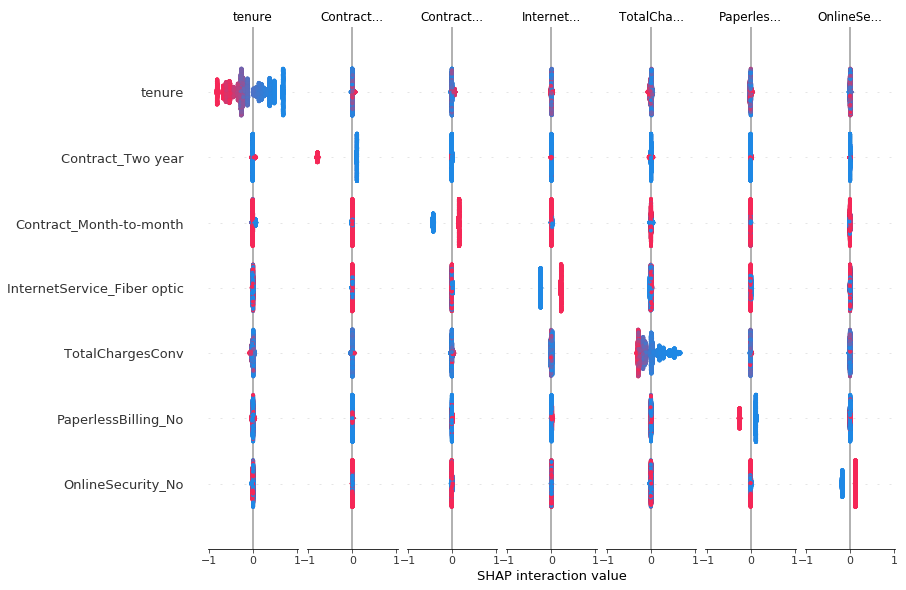

In [96]:
import shap

shap.summary_plot(shap_inter, df.drop(cols_drop, axis=1))

In [ ]:
## This is a very important interaction that can't be over-emphesised. 

Here you can see something very interesting, only if you sign or regularly sign two-year contracts does your tenure matter. Thus if you have already signed two year contracts, you are more likley to sign contracts in the future. On the other hand if you have been tenured for very long withu

In [106]:
df.head()

,customerID,Churn,is_test,tenure,MonthlyCharges,TotalChargesConv,gender_Female,SeniorCitizen_0,Partner_No,Dependents_No,...,StreamingMovies_No,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,7590-VHVEG,0,False,1,29.85,29.85,1,1,0,1,...,1,0,1,0,0,0,0,0,1,0
1,5575-GNVDE,0,False,34,56.95,1889.50,0,1,1,1,...,1,0,0,1,0,1,0,0,0,1
2,3668-QPYBK,1,False,2,53.85,108.15,0,1,1,1,...,1,0,1,0,0,0,0,0,0,1
3,7795-CFOCW,0,False,45,42.30,1840.75,0,1,1,1,...,1,0,0,1,0,1,1,0,0,0
4,9237-HQITU,1,False,2,70.70,151.65,1,1,1,1,...,1,0,1,0,0,0,0,0,1,0


Females are less willing to change providers if they have been with the company for a long time, males are more likley to churn and do not show as much loyalty as females.

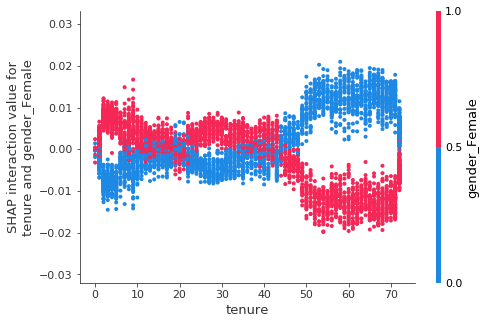

In [108]:
shap.dependence_plot(
    ("tenure", "gender_Female"),
    shap_inter, df.drop(cols_drop, axis=1),
    display_features=df.drop(cols_drop, axis=1)
)

Young people are more likley to churn if they have been with the company for a long time as opposed to old people

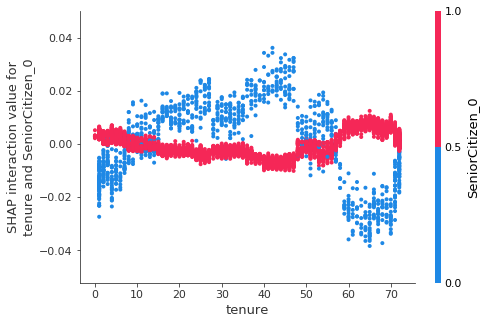

In [109]:
shap.dependence_plot(
    ("tenure", "SeniorCitizen_0"),
    shap_inter, df.drop(cols_drop, axis=1),
    display_features=df.drop(cols_drop, axis=1)
)

Customers are a lot less likley to churn if they have spent exhorborant amounts on fees and have been with the company for a long time. It is likley that these companies have gained favour due to be long term customers, so this might have less to do with their total charges than their current rates. 

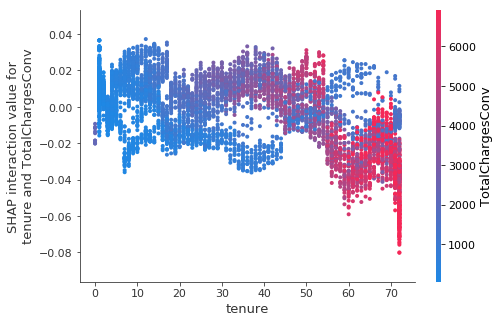

In [111]:
shap.dependence_plot(
    ("tenure", "TotalChargesConv"),
    shap_inter, df.drop(cols_drop, axis=1),
    display_features=df.drop(cols_drop, axis=1)
)

In [115]:
df.head()

,customerID,Churn,is_test,tenure,MonthlyCharges,TotalChargesConv,gender_Female,SeniorCitizen_0,Partner_No,Dependents_No,...,StreamingMovies_No,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,7590-VHVEG,0,False,1,29.85,29.85,1,1,0,1,...,1,0,1,0,0,0,0,0,1,0
1,5575-GNVDE,0,False,34,56.95,1889.50,0,1,1,1,...,1,0,0,1,0,1,0,0,0,1
2,3668-QPYBK,1,False,2,53.85,108.15,0,1,1,1,...,1,0,1,0,0,0,0,0,0,1
3,7795-CFOCW,0,False,45,42.30,1840.75,0,1,1,1,...,1,0,0,1,0,1,1,0,0,0
4,9237-HQITU,1,False,2,70.70,151.65,1,1,1,1,...,1,0,1,0,0,0,0,0,1,0


If your total charges are high but you are on month to month, you are less likley to jump ship, because you do not feel constrained. So this might be a ptential method to get more total slaes, convert to monthly

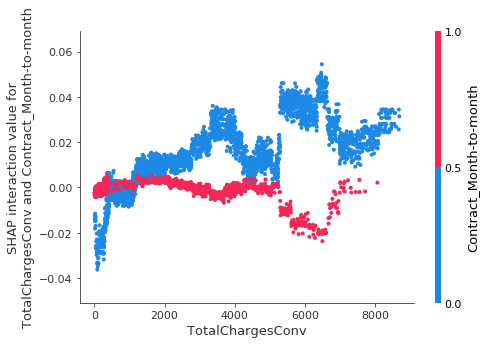

In [117]:
shap.dependence_plot(
    ("TotalChargesConv","Contract_Month-to-month"),
    shap_inter, df.drop(cols_drop, axis=1),
    display_features=df.drop(cols_drop, axis=1)
)

This can help you understand certain price points. Similar to shelley points in game theory. There is certain values that customers just flat out do not like. When the price increases from 40 to 50 customers are unhappy, it migth be pshychological or the company is infact losing out at that price point against the market. From price point 60 - 90 the firm seems to be doing reasonably well in retaining customer etc.

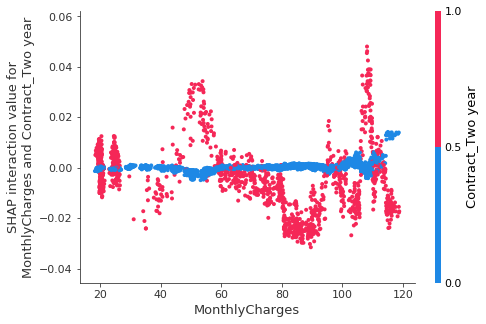

In [118]:
shap.dependence_plot(
    ("MonthlyCharges","Contract_Two year"),
    shap_inter, df.drop(cols_drop, axis=1),
    display_features=df.drop(cols_drop, axis=1)
)

These partial dependence plots and correlation plots will 99% of the tme show the same relationship. The only issue is that with the corerlation plot you have to create groupby's  

This chart shows something concerning, 

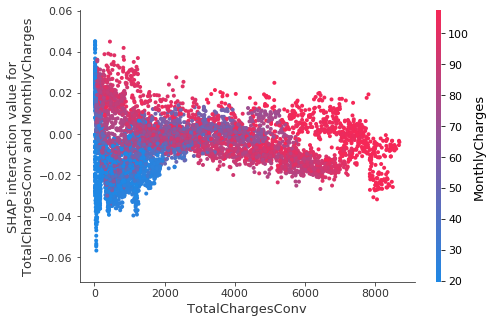

In [119]:
shap.dependence_plot(
    ("TotalChargesConv","MonthlyCharges"),
    shap_inter, df.drop(cols_drop, axis=1),
    display_features=df.drop(cols_drop, axis=1)
)

In [120]:
cols_drop

['customerID', 'Churn', 'is_test']

['Contract_Month-to-month',
 'tenure',
 'Contract_Two year',
 'TotalChargesConv',
 'TechSupport_No',
 'Contract_One year',
 'OnlineSecurity_No',
 'DeviceProtection_No',
 'PaymentMethod_Electronic check',
 'OnlineBackup_No']

In [133]:
kt

['Contract_Month-to-month',
 'tenure',
 'Contract_Two year',
 'TotalChargesConv',
 'TechSupport_No',
 'Contract_One year',
 'OnlineSecurity_No',
 'DeviceProtection_No',
 'PaymentMethod_Electronic check',
 'OnlineBackup_No',
 'Churn']

In [134]:
df[kt].head()

,Contract_Month-to-month,tenure,Contract_Two year,TotalChargesConv,TechSupport_No,Contract_One year,OnlineSecurity_No,DeviceProtection_No,PaymentMethod_Electronic check,OnlineBackup_No,Churn
0,1,1,0,29.85,1,0,1,1,1,0,0
1,0,34,0,1889.50,1,1,0,0,0,1,0
2,1,2,0,108.15,1,0,0,1,0,0,1
3,0,45,0,1840.75,0,1,0,0,0,1,0
4,1,2,0,151.65,1,0,1,1,1,1,1


In [138]:
df["Churn"].value_counts()

0    5174
1    1869
Name: Churn, dtype: int64

/Users/dereksnow/anaconda/envs/py36/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
/Users/dereksnow/anaconda/envs/py36/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/Users/dereksnow/anaconda/envs/py36/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


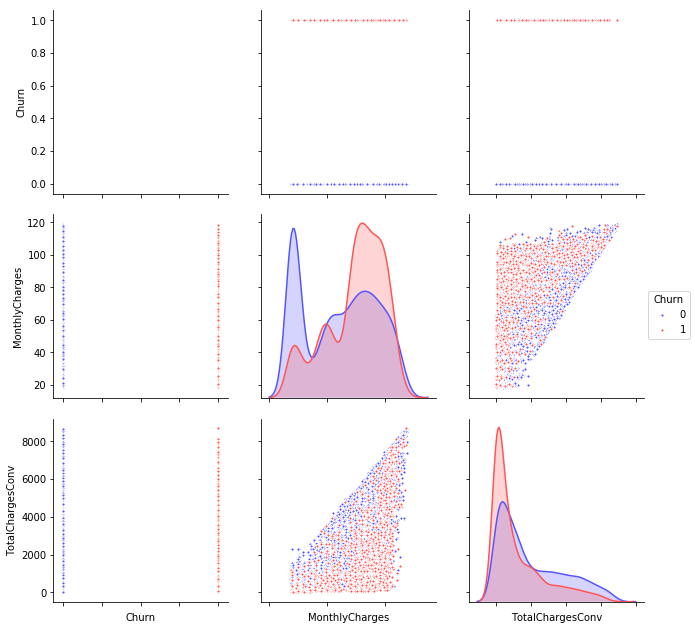

In [145]:
import seaborn as sns

kt = list(shap_fin.sort_values("SHAP_corr",ascending=False).index[:4])
kt = []
kt.append("Churn")
kt.append("MonthlyCharges")
kt.append("TotalChargesConv")
g = sns.pairplot(df[kt], hue='Churn', palette = 'seismic',size=3,diag_kind = 'kde',diag_kws=dict(shade=True),plot_kws=dict(s=10) )
g.set(xticklabels=[])

In [ ]:
## You are more likely to churn with high monthly charges and low total cost.
## You are not as likley to churn with high monthly charges and high monthly costs.
## See it shows the same relationship
## What it does unfortunately not show is the probability of being this and that as it is single points. 
## For that you might have to do a nearest neighbour transofmration or a strategised groupby.
## and that is simply what the tree provides, see it as a groupby function, in out example it is just not 
## entirely overfitted, so some information might be lost, but not necessarily if generalisability is important. 
## With scatter plots you have to do it with actual or expected values. 
## I have neverv seen expected value plots because to create it you would have to create some groupbys or knn's
## so inface your LightGBM is the expected value amounts - nothing can actually get as close as it, hence why it
## is used. And the expected value plot gives you a slightly better picture than colored scatter plots for categorical.
## However, for regression plots, it is going to show a very similar plot. - You can at a a later stage try that out 
## for regression plots. So I would recommend using the shap dependence plots when it comes to classification
## and maybe switching  to scater plots when it comes to regression. There is also an argument to just use the
## the scatter plots as the relationship might become moot as a result of another correlated vairable.